In [1]:
import scipy
from dataset.dataset import *
from bandit_toy import *
from matplotlib import pyplot as plt
plt.rc('font', family='Times New Roman',size=16)
args = bandit_get_args()
marginal_prob_std_fn = functools.partial(marginal_prob_std, device=args.device)
score_model= Bandit_MlpScoreNet(input_dim=2, output_dim=2, marginal_prob_std=marginal_prob_std_fn, args=args).to(args.device)

def energy_sample(env, ss, sample_per_state=1000, **kwargs):
    data, e = inf_train_gen(env,batch_size=1000*sample_per_state)
    ori_e = e
    e = e * ss

    index = np.random.choice(1000*sample_per_state, p=scipy.special.softmax(e).squeeze(), size=sample_per_state, replace=False)
    data = data[index]
    ori_e = ori_e[index]
    return data, ori_e


/workspace/home/huayu/miniconda3/envs/tianshouenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No module named 'mjrl'
No module named 'flow'
No module named 'dm_control'
No module named 'carla'
No module named 'pybullet_envs'


**************************
Namespace(alpha=3.0, debug=0, device='cuda', diffusion_steps=15, env='8gaussians', expid='default', method='CEP', save_model=1, seed=0)


moons
moons
moons
moons
8gaussians
8gaussians
8gaussians
8gaussians
swissroll
swissroll
swissroll
swissroll
swissroll
swissroll
swissroll
swissroll
rings
rings
rings
rings
checkerboard
checkerboard
checkerboard
checkerboard
2spirals
2spirals
2spirals
2spirals


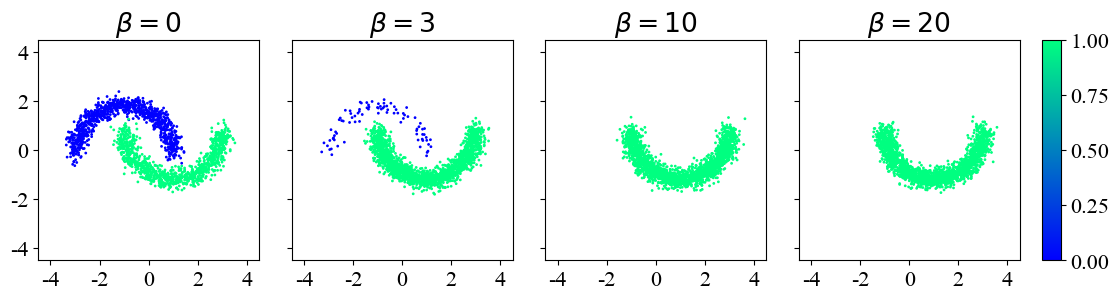

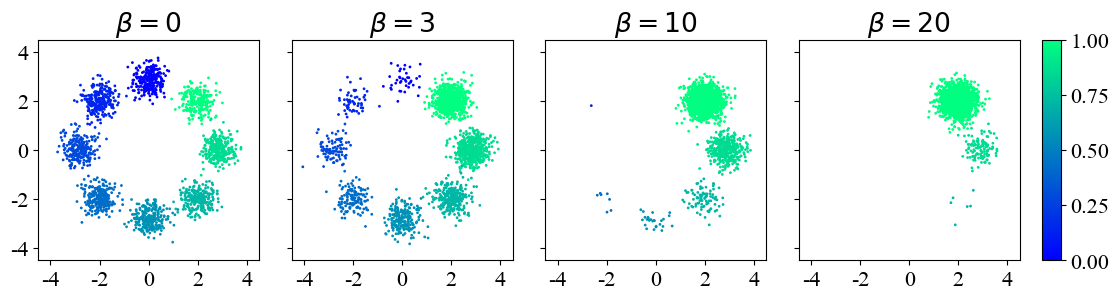

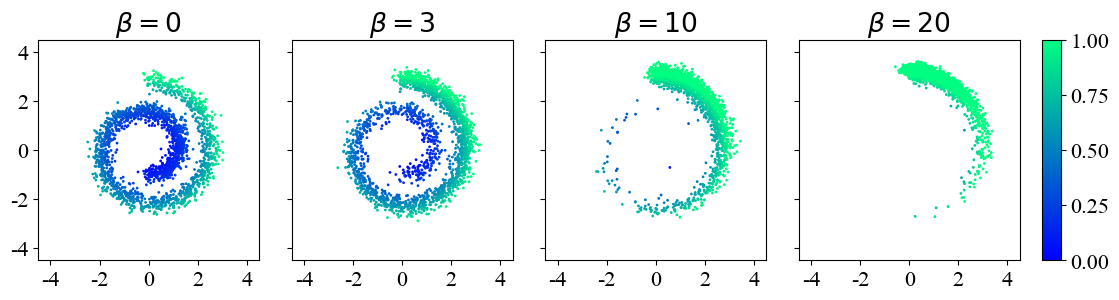

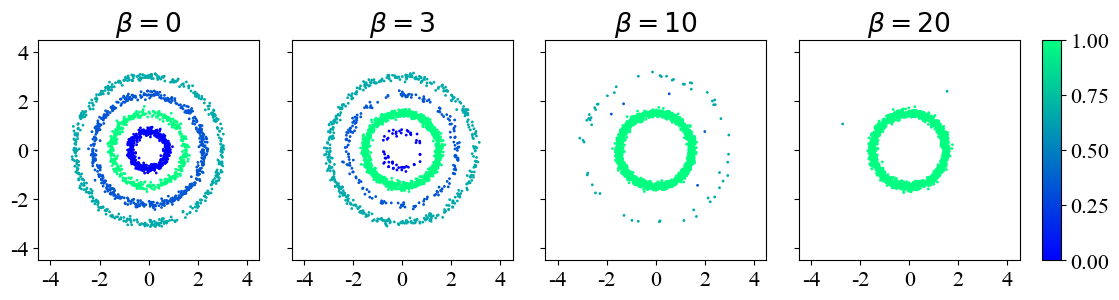

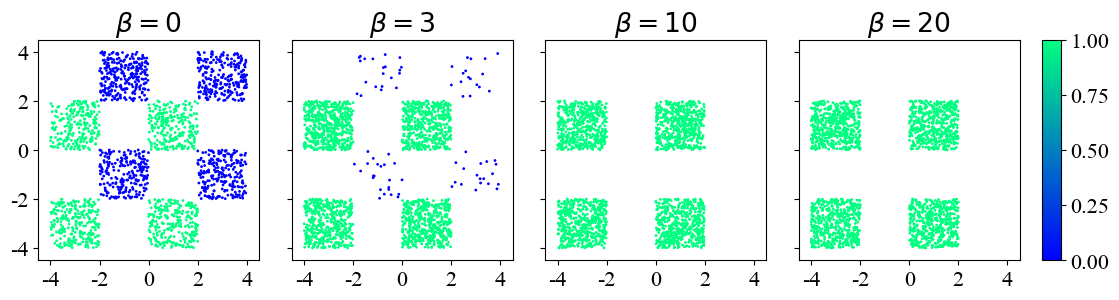

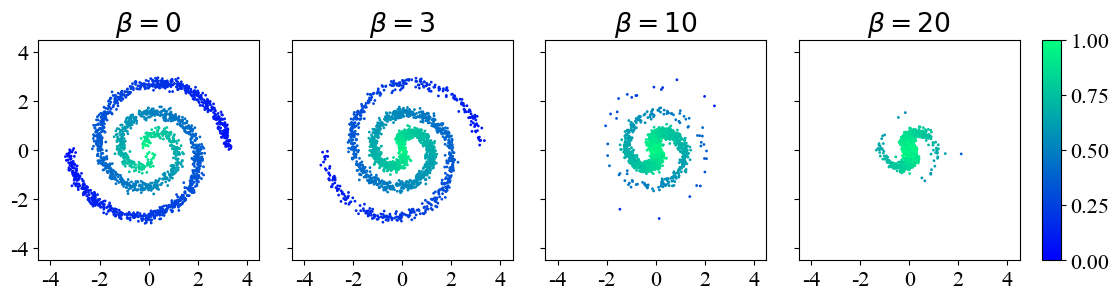

In [2]:
# scatter ground truth
for task in ["moons", "8gaussians", "swissroll","rings","checkerboard","2spirals"]:
    plt.figure(figsize=(12,3.0))
    ss = [0,3, 10,20]
    axes = []
    for i, s in enumerate(ss):
        plt.subplot(1, len(ss), i+1)
        data, e = energy_sample(task, s, sample_per_state=2000)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlim(-4.5,4.5)
        plt.ylim(-4.5,4.5)
        if i == 0:
            mappable = plt.scatter(data[:,0],data[:,1],s=1,c=e,cmap="winter",vmin=0,vmax=1, rasterized=True)
            plt.yticks(ticks=[-4, -2, 0, 2, 4],labels=[-4, -2, 0, 2, 4])
        else:
            plt.scatter(data[:,0],data[:,1],s=1,c=e,cmap="winter",vmin=0,vmax=1, rasterized=True)
            plt.yticks(ticks=[-4, -2, 0, 2, 4],labels=[None, None, None, None, None])
        axes.append(plt.gca())
        plt.xticks(ticks=[-4, -2, 0, 2, 4],labels=[-4, -2, 0, 2, 4])
        plt.title(r'$\beta={}$'.format(s))
    plt.tight_layout()
    plt.gcf().colorbar(mappable, ax=axes, fraction=0.1, pad=0.02, aspect=12)


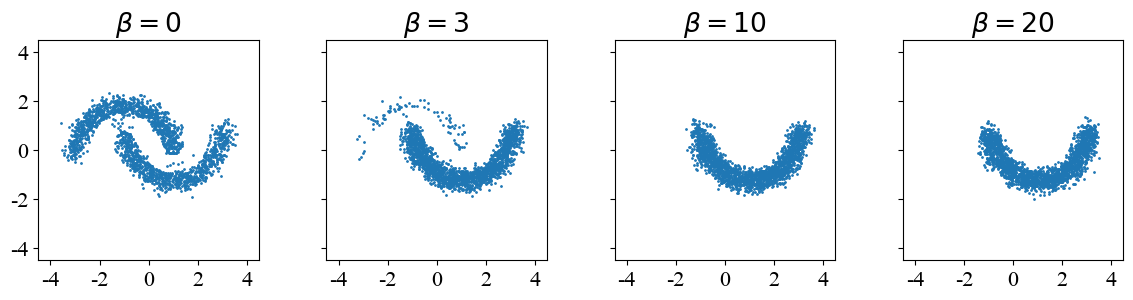

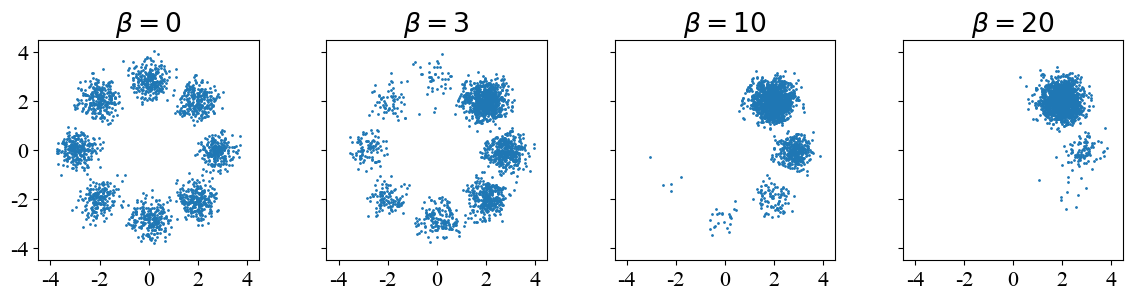

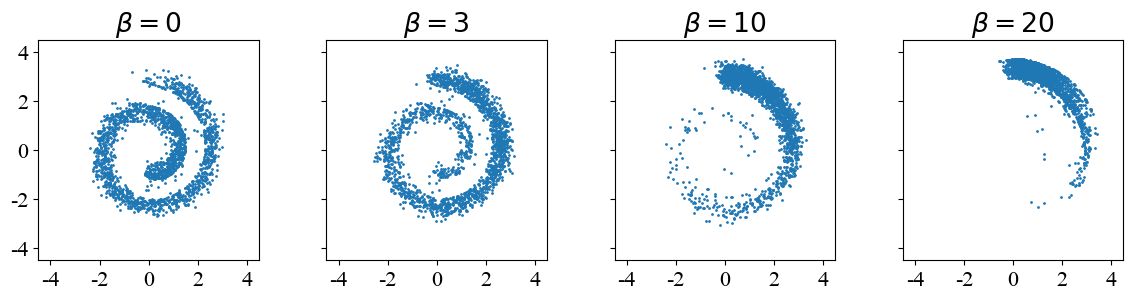

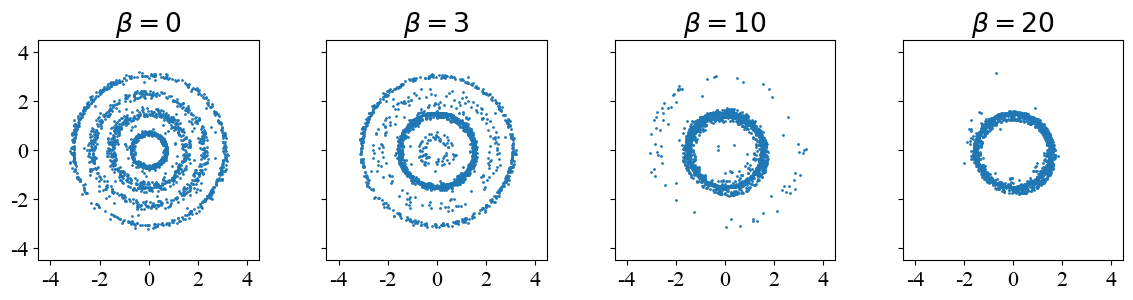

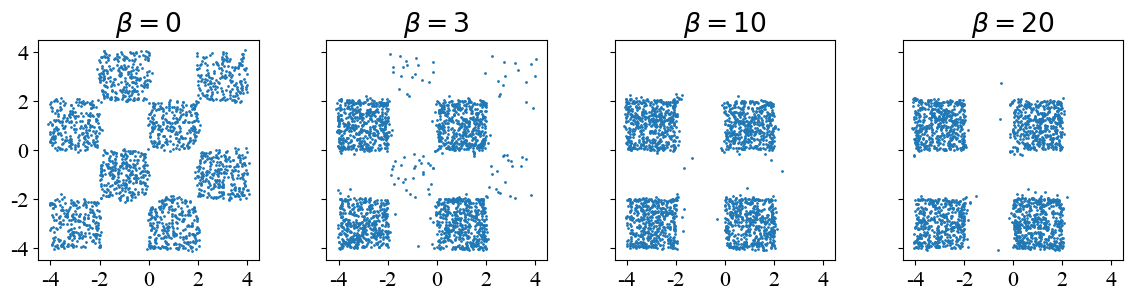

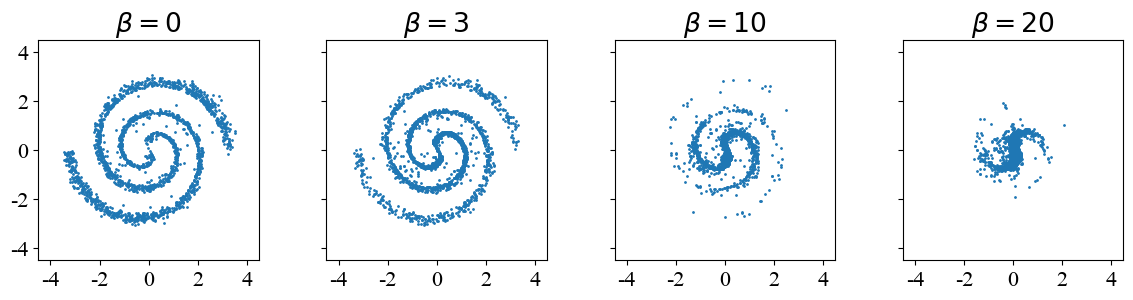

In [14]:
method = "CEP" # ["mse", "emse", "CEP"]
for task in ["moons", "8gaussians", "swissroll","rings","checkerboard","2spirals"]:
    plt.figure(figsize=(12,3.0))
    ss = [0,3, 10,20]
    axes = []
    for i, s in enumerate(ss):
        plt.subplot(1, len(ss), i+1)
        alpha=s
        ckpt = torch.load("./models/{}0large2{}_alpha{}/ckpt750.pth".format(task, method, alpha if alpha > 2 else 3), map_location=args.device)
        score_model.load_state_dict(ckpt)

        ckpt = torch.load("./models/{}0large2{}_alpha{}/critic_ckpt750.pth".format(task, method, alpha if alpha > 2 else 3), map_location=args.device)
        score_model.q[0].load_state_dict(ckpt)

        score_model.q[0].guidance_scale = 1.0 if alpha >1 else 0.0
        data = score_model.sample(None, sample_per_state=2000, diffusion_steps=25)

        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlim(-4.5,4.5)
        plt.ylim(-4.5,4.5)
        if i == 0:
            mappable = plt.scatter(data[:,0],data[:,1],s=1, rasterized=True)
            plt.yticks(ticks=[-4, -2, 0, 2, 4],labels=[-4, -2, 0, 2, 4])
        else:
            plt.scatter(data[:,0],data[:,1],s=1, rasterized=True)
            plt.yticks(ticks=[-4, -2, 0, 2, 4],labels=[None, None, None, None, None])
        axes.append(plt.gca())
        plt.xticks(ticks=[-4, -2, 0, 2, 4],labels=[-4, -2, 0, 2, 4])
        plt.title(r'$ \beta ={}$'.format(s))
    plt.tight_layout()


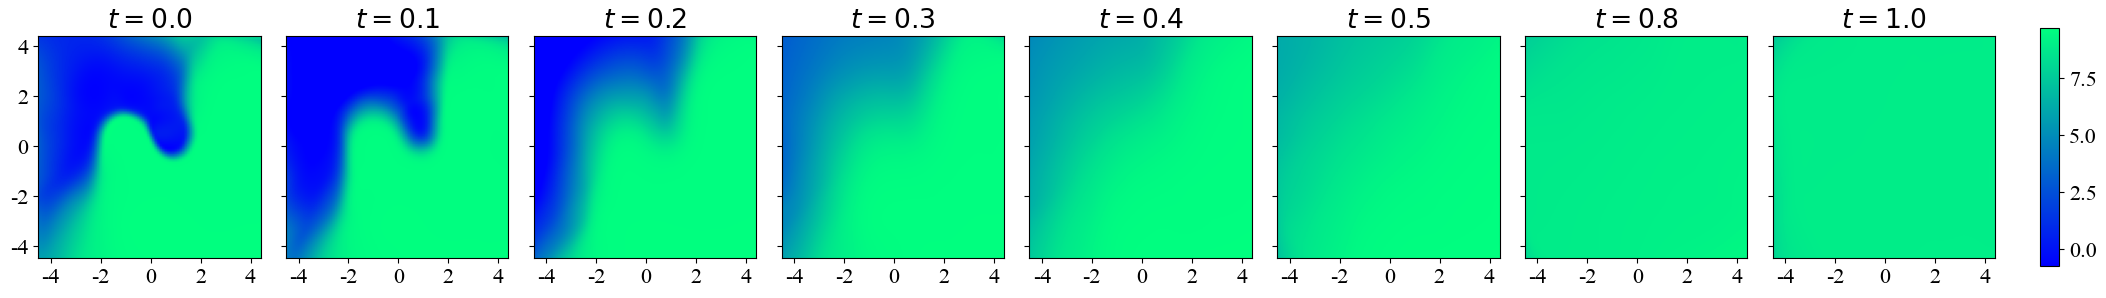

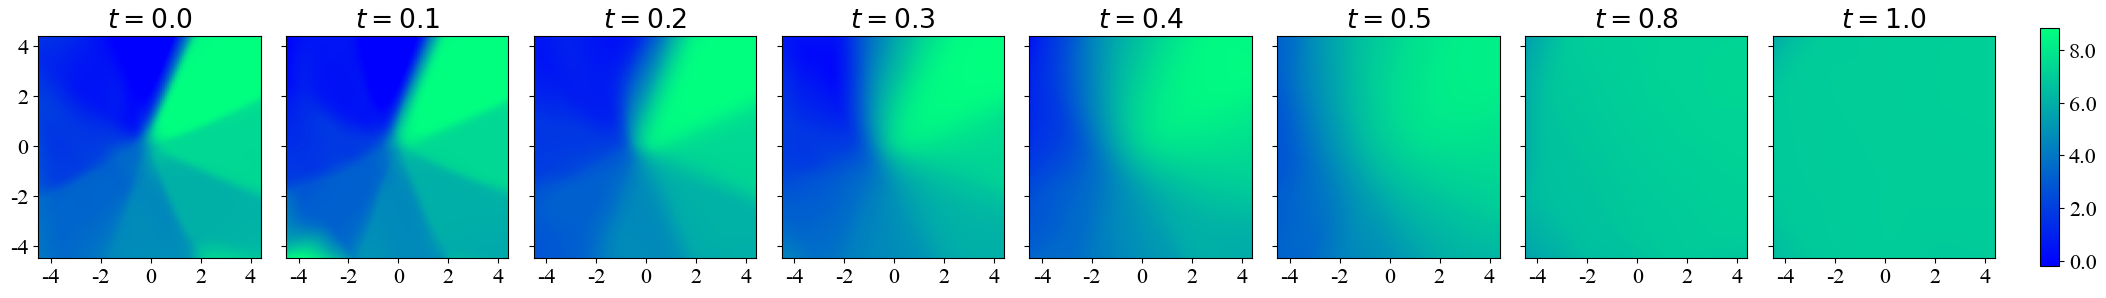

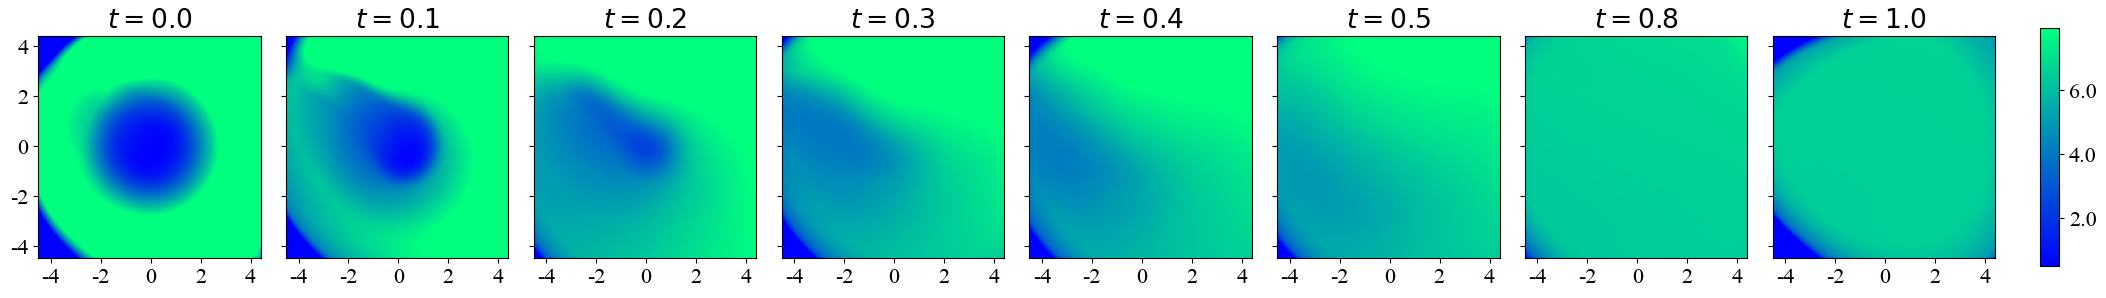

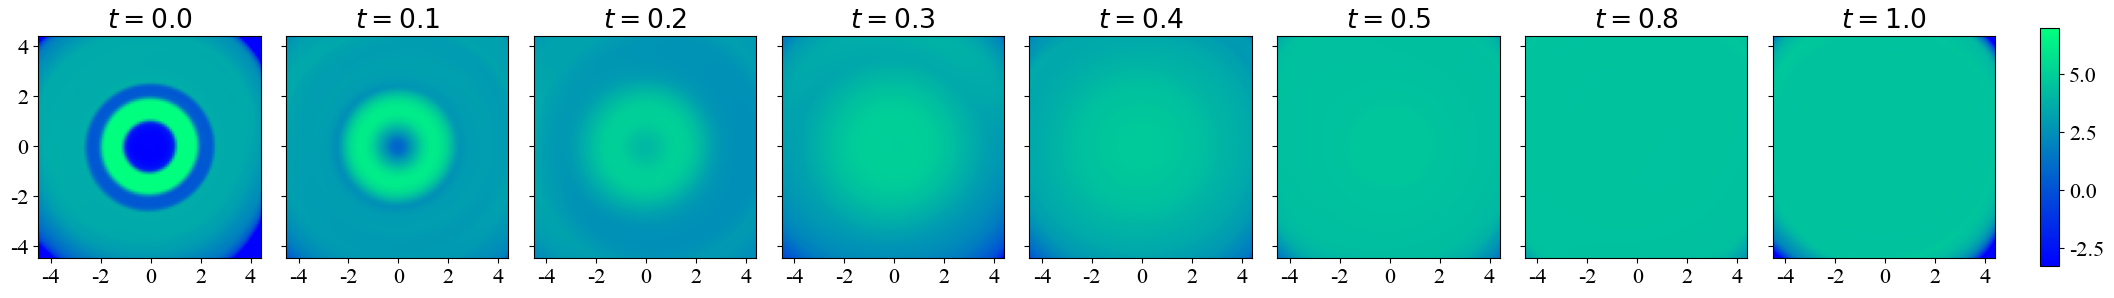

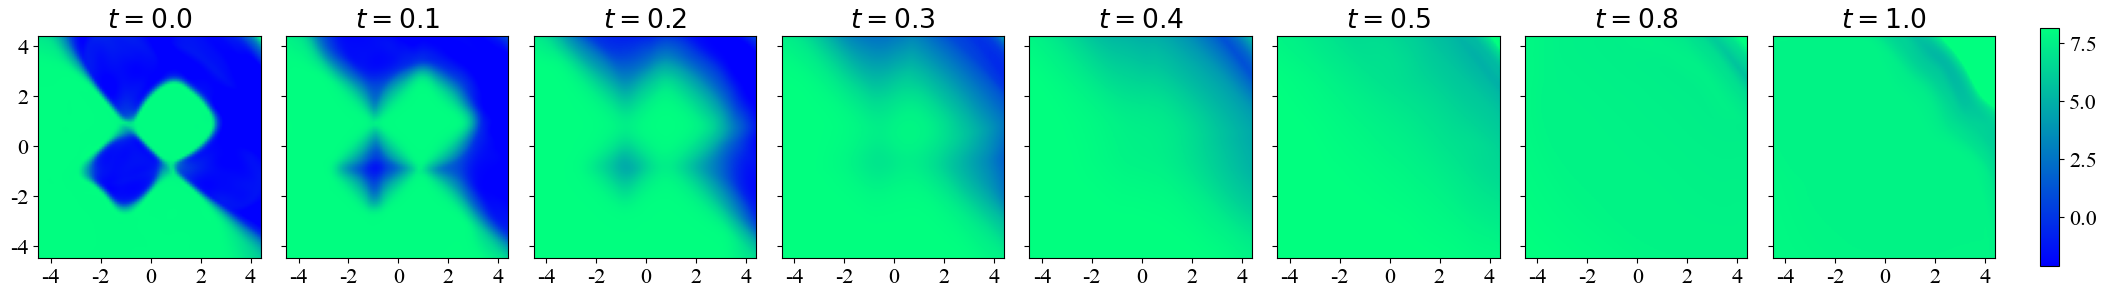

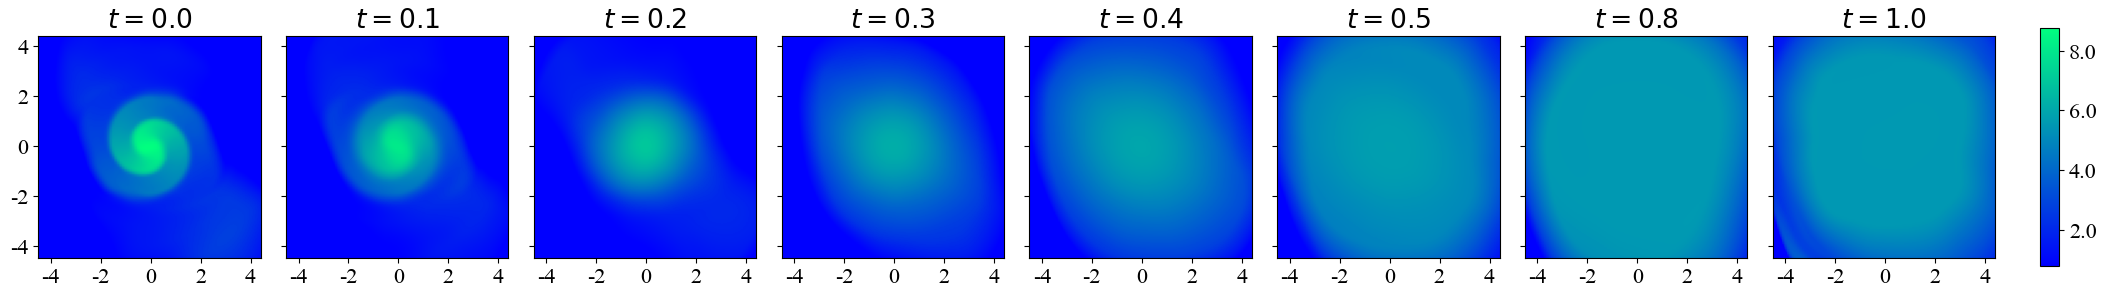

In [15]:
# draw qt space beta =10
method = "CEP"
task = "8gaussians"
plt.rc('font', family='Times New Roman',size=16)

x_range = torch.linspace(-4.5,4.5,90)
y_range = torch.linspace(-4.5,4.5,90)
a,b = torch.meshgrid(x_range, y_range, indexing='ij')
id_matrix = torch.stack([b,a],dim=-1).to("cuda")
one = torch.ones((90,90)).to("cuda")
alpha=10


for task in ["moons", "8gaussians", "swissroll","rings","checkerboard","2spirals"]:
    plt.figure(figsize=(23,3.0))
    tt = [0.0,0.1,0.2,0.3,0.4,0.5,0.8,1.0]
    axes = []

    ckpt = torch.load("./models/{}0large2{}_alpha{}/ckpt750.pth".format(task, method, alpha if alpha > 2 else 3), map_location=args.device)
    score_model.load_state_dict(ckpt)

    ckpt = torch.load("./models/{}0large2{}_alpha{}/critic_ckpt750.pth".format(task, method, alpha if alpha > 2 else 3), map_location=args.device)
    score_model.q[0].load_state_dict(ckpt)

    data_samples = score_model.q[0].qt(id_matrix, one * 0.0, None).cpu().detach().numpy()
    vmin = data_samples[25:65,25:65].min()
    vmax = data_samples[25:65,25:65].max()

    for i, t in enumerate(tt):
        plt.subplot(1, len(tt), i+1)
        c = score_model.q[0].qt(id_matrix, one * t, None).cpu().detach().numpy()
        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlim(0,89)
        plt.ylim(0,89)
        if i == 0:
            mappable=plt.imshow(c[:,:,0],origin ='lower', vmin=vmin, vmax=vmax,cmap="winter", rasterized=True)
            plt.yticks(ticks=[5, 25, 45, 65, 85],labels=[-4, -2, 0, 2, 4])
        else:
            plt.imshow(c[:,:,0],origin ='lower', vmin=vmin, vmax=vmax,cmap="winter", rasterized=True)
            plt.yticks(ticks=[5, 25, 45, 65, 85],labels=[None, None, None, None, None])
        axes.append(plt.gca())
        plt.xticks(ticks=[5, 25, 45, 65, 85],labels=[-4, -2, 0, 2, 4])
        plt.title('$t={}$'.format(t))
    plt.tight_layout()
    cbar=plt.gcf().colorbar(mappable, ax=axes, fraction=0.1, pad=0.02, aspect=12)
    import matplotlib
    plt.gcf().axes[-1].yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.1f'))
